# **Creating anime characters using Deep Convolutional Generative Adversarial Networks (DCGANs) and Keras**


Imagine if you are in a video game company, your games is famous for its unique characters for every player. With the growth of the player amount, it comes to be a nearly impossible mission to hand plot the characters for millions of players. Your boss plans to keep the unique character creating function in the game, and you need a method to handle the task. <br>

__Generative adversarial networks (GANs) might help!__<br>
It is a class of machine learning frameworks, first published in June 2014 <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>. <br>
GANs could generate new data following the statistic features of the data in the training set. GANs is widely used to generate new and realistic photograph that is authentic to human observers. <br>

Convolutional networks (CNNs) has seen huge adoption in computer vision applications. Applying the CNNs to GANs models could help us in building a photo generating model. The combined method is called Deep Convolutional Generative Adversarial Networks (DCGANs). <br>

In this lab, we will first focus on simulated data to better understand GANs. <br>
Further, we will use the case of massive anime avatar production to introduce how to use DCGANs.<br>
__You will create anime characters like the ones below in this project.__

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/face_cartton.png" width="700" alt="Skills Network Logo">


----
<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/unknown4.jpeg" width="50%"></center>


----


### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_

_You need ~1 minute to import._


In [9]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU
import time

tensorflow version: 2.10.1


In [10]:
import keras

In [11]:
from IPython import display
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

skillsnetwork version: 0.21.9


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import os
from os import listdir
from pathlib import Path
import imghdr

In [14]:
from tqdm import tqdm

### Defining Helper Functions


In [1]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_distribution(real_data,generated_data,discriminator=None,density=True):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')

    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()

def plot_array(X,title=""):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

----


## Basic: Generative Adversarial Networks (GANs)


### Introduction


__Generative Adversarial Networks (GANs)__ are generative models that convert random samples of one distribution into another distribution. They have several applications, like the following:

*  Generate Examples for Image Datasets
*  Generate Photographs of Human Faces
*  Generate Realistic Photographs
*  Generate Cartoon Characters
*  Image-to-Image Translation
*  Text-to-Image Translation
*  Face Frontal View Generation
*  Generate New Human Poses
*  Face Aging
*  Photo Blending
*  Super Resolution
*  Photo Inpainting
*  Clothing Translation
*  Video Prediction

In this GANs section of the Lab, we will use a toy example to help understand the __basic theoretical principles__ behind GANs. The original form of GANs consisted of a __discriminator__ and a __generator__; let's use the analogy of a currency forger and the police.

The Generator is the currency forger, and the output is the counterfeit, for example, a 100-dollar bill. The discriminator is analogous to the police taking the counterfeit and trying to determine if it's real by comparing it to a real $100 bill. In real life, if the counterfeit is easy to detect, the forger will adapt; conversely, the police will also improve; GANs emulate this game of cat and mouse.  

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/General%20diagram.png" alt="generator image" width="700px"></center>

What makes GANs interesting is that the __discriminator and generator continuously improve__ each other by a well-formulated cost function that backpropagates the errors. GANs are a family of algorithms that use _learning by comparison_. In the lab, we will review the original formulation and use a simulated dataset. We will also point you to some more advanced methods and issues you will encounter with the real datasets for the next lab.


### Toy Data

Consider the following data, $\mathbf{x}$, that is normally distributed $\mathbf{x} \sim \mathcal{N}(\mathbf{x}|10,1) $ with a mean of 10 and a standard deviation of 1. Now we would like to randomly sample data from this distribution.


In [ ]:
mean = [10]
cov = [[1]]
X = tf.random.normal((5000,1),mean=10,stddev=1.0)

print("mean:",np.mean(X))
print("standard deviation:",np.std(X))

mean: 10.010632
standard deviation: 0.9995141


We also have the data sample, z, which is also normally distributed $\mathbf{z} \sim \mathcal{N}(\mathbf{z}|0,2) $, with mean of 0 and a standard deviation of 2:



In [ ]:
Z = tf.random.normal((5000,1),mean=0,stddev=2)

In [ ]:
print("mean:",np.mean(Z))
print("standard deviation:",np.std(Z))

mean: -0.01500372
standard deviation: 2.0095174


Let's compare the two distributions:


In [ ]:
plot_distribution(X,Z,discriminator=None,density=True)

: 

Let's create our first generative model by adding 10 to every sample of $z$. We will call the result $\hat{\mathbf{x}}$  as it's an approximation of $\mathbf{x}$. It is not too difficult to show that $\hat{\mathbf{x}} \sim \mathcal{N}(\mathbf{x}|10,1)$.Xhat=Z+10


In [ ]:
Xhat=Z+10

We see that the mean and standard deviation are almost identical


In [ ]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: 10.014467
standard deviation: 1.9951222


Similarly for the histograms


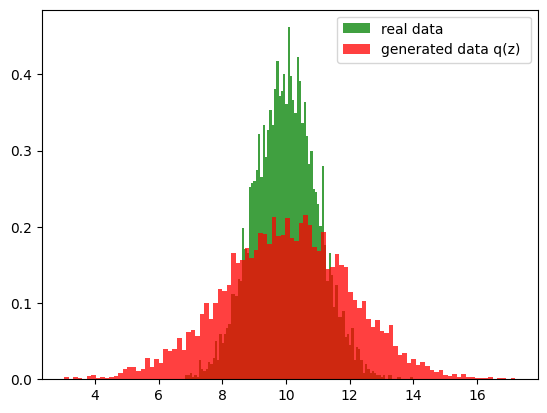

In [ ]:
plot_distribution(X,Xhat,discriminator=None,density=True)

In the case above, since we just add 10 to the latent variable $z$, we transform $z$ using a deterministic function. We can call this an implicit generative model.


### The Generator


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/Unknown.png" width="300px">

There are two networks involved in a GAN, the Generator and the Discriminator. Let's understand the Generator network first.

The Generator is a neural network denoted by $G$; the idea is that a neural network can approximate any function (by the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01)), so you should be able to generate data samples from any type of distribution.

Our goal is to convert the samples, $\mathbf{z}$, to one that approximates $\hat{\mathbf{x}}$,  i.e $\hat{\mathbf{x}}=G(\mathbf{z})$. Let's build a simple Generator $G(\mathbf{z})=\mathbf{W}^{T}\mathbf{z}+\mathbf{b} $ using Keras.

The following is a function that outputs a generator using Kera's Sequential model object.


In [ ]:
def make_generator_model():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

We can use the Generator to convert $\mathbf{z}$ and make a prediction $\hat{\mathbf{x}}$, and display the histogram of the distributions of $\hat{\mathbf{x}}$ and $\mathbf{x}$. As the model is not trained, the trained distributions are quite different:


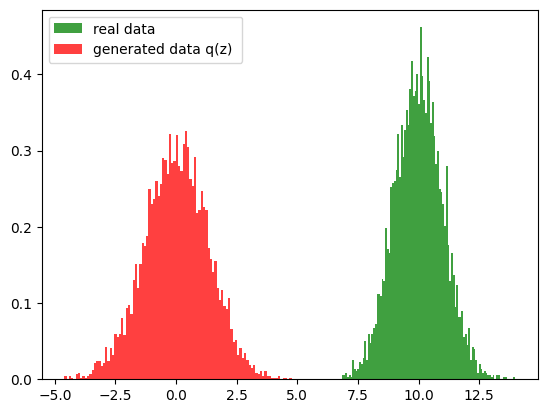

In [ ]:
generator=make_generator_model()

Xhat = generator(Z, training=False)
plot_distribution(real_data=X,generated_data=Xhat)

We will discuss the use of the parameter ```training=False``` later on.


### The Discriminator


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/Unknown1.png" width="300px">

The discriminator $D(\mathbf{x})$ is a neural network that learns to distinguish between actual and generated samples. The simplest Discriminator is a simple logistic regression function. Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function, which is the convention in Keras.


In [ ]:
def make_discriminator_model():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=make_discriminator_model()

The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis. We also include the threshold. If the output of the logistic function is less than 0.5, the sample is classified as generated data; conversely, if the output is greater than 0.5, the sample will be classified as data that came from the real distribution.


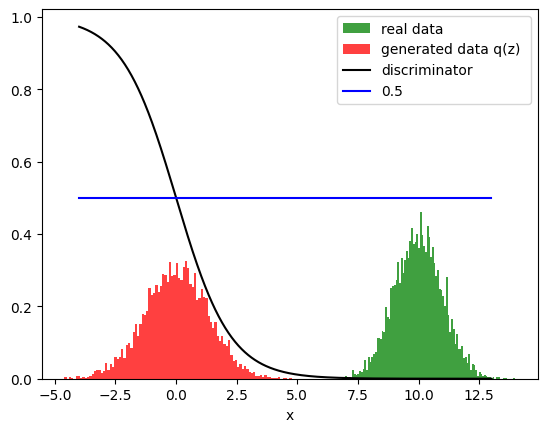

In [ ]:
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator)

Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:


In [ ]:
py_x=tf.math.sigmoid(discriminator(X,training=False))
np.sum(py_x>0.5)

0

For the generated data, only a part of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.


In [ ]:
py_x=discriminator(Xhat)
np.sum(py_x>0.5)

1648

We can also use the following to find the average value of the sigmoid function for all the samples.  


In [ ]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [ ]:
get_accuracy(X,Xhat)

0.24883176386356354

In many cases, we can instead study the difference in the distribution; in this case, the discriminator is called a <a href='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/2107.06700.pdf'>Critic</a>, a real-valued function.


### The Loss Function GANs (Optional)
GANs convert an unsupervised learning problem to a supervised one. Instead of formulating the problem like a two-player minimax game with a value function like in <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>, we can treat the problem of maximizing the familiar log-likelihood of the logistic function analogous to minimizing the cross-entropy loss, then incorporate the generator and discriminator.

___Discriminator___

In order to train the GANS, we start off with standard maximization of the likelihood for the discriminator for the standard dataset $\mathcal{D}=\{{(x_1, y_1), ..., (x_N, y_N)}\}$:

$$V(D)=\sum_{n=1}^N \left( y_n \ln(D(\mathbf{x}_n))+(1-y_n) \ln(1-D(\mathbf{x}_n))\right)$$

Where $y=1$ for samples from the true distribution and $y=0$ for samples from the generator. The goal is to maximize this term with respect to $D$:

$$max_{D}(V(D))$$


To also incorporate the generated samples, we augment the right side of the equation with the generated $k$th sample $\hat{\mathbf{x}}_k$. As they are not part of the dataset $k \notin \mathcal{D} $, we have to include a second summation where $y=0$. Finally, combining the cases of $y=1$ and $y=0$, we get:

$$V(D)=\sum_{ n	\in \mathcal{D}}  \ln(D(\mathbf{x}_n))+\sum_{k 	\notin \mathcal{D}} \ln(1-D(\hat{\mathbf{x}}_k) ) $$


___Generator___

For the generator we simply replace $\hat{\mathbf{x}}_k$ with the $G(\mathbf{z}_k)$ .


$$V(G,D)=\sum_{n	\in \mathcal{D}} \ln(D(\mathbf{x}_n))+\sum_{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}_k))) $$

As this is a density estimation problem, it is common to replace the summation with the expected value like in <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>. We replace the summations with an expectation where $p(\mathbf{x})$ is the true distribution and $p(\mathbf{z})$ is the distribution of $\mathbf{z}$.


$$V(D,G)=\mathbb{E}_{x\sim p(\mathbf{x})} \ln(D(\mathbf{x})) + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})} \ln(1-D(G(\mathbf{z}) )) $$

As we are trying to trick the discriminator, we would like to find a $G$ that minimize the above expression, such as:

$$min_{G} max_{D} V(D,G)$$


### Training GANs

GANs are quite difficult to train, even for a simple example. Let's start off with training the generator in practice.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/unknown3.jpeg" width="500px">

___Training Generator___

$log(1 − D(G(\mathbf{z})))$ is difficult to work with as $D(G(\mathbf{z}))$ is near one or zero for the first few iterations. This is because the generator is not yet properly trained, and the discriminator can easily distinguish between the generated and actual samples. Therefore we maximize $log(D(G(\mathbf{z}_k)) )$.

Although the output of the generator passes through the discriminator, we do not update the generator in the optimization step, hence we set the parameter ```training=False``` in the actual training steps.


Instead of maximizing the term, we can take the negative and minimize it. The resultant expression can be calculated in Keras using the cross-entropy loss where all the target values are set to one:

$$\sum_{k 	\notin \mathcal{D}} log(1 - D(G(\mathbf{z}_k)) )$$


In [ ]:
# This method returns a helper function to compute crossentropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

___Training Discriminator___

We can also use the cross-entropy to train the discriminator; we simply multiply $V(G,D)$ by a negative number, set $y=0$ for the generated values and $y=1$ for the real values. We do not update the generator parameters.

$$V(G)=\sum_{n	\in \mathcal{D}} (\ln(D(\mathbf{x}_n)))+\sum_{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}_k) )) $$


The first term is the real loss and the second is the fake loss in Keras.


In [ ]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

We create the optimizer for the discriminator and generator:


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)

discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)

We now train the model; as the dataset is small, we will use batch gradient descent.

For each iteration we will generate $M$ real examples $\{\mathbf{x}_{1}, ...,\mathbf{x}_{M}\}$, these are from the generating distribution $p(\mathbf{x})$. This would be our actual dataset if we used real data.  

We will then generate a sample batch of $M$ noise samples $\{\mathbf{z}_{1}, ...,\mathbf{z}_{M}\}$ from noise prior $p(\mathbf{z})$ and convert the result to a generated image using the generator $\{\hat{\mathbf{x}}_{1}, ...,\hat{\mathbf{x}}_{M}\}$.

We determine the output of the discriminator for both the real and generated samples. We calculate the loss and then update the discriminator and generator through their respective stochastic gradients.


The convergence of GAN training is a subject in itself. But let's explore a method that works for this simple dataset. Intuitively, we know that if our generated data is identical to our actual data, the probability of correctly classifying is random. Therefore if the generated and actual data are of equal proportion, $D(\mathbf{x}_n)=0.5$ and $D(\hat{\mathbf{x}}_n)=0.5$.  

We only display iterations where the average discriminator output gets closer to 50% for both the generated data and actual data.


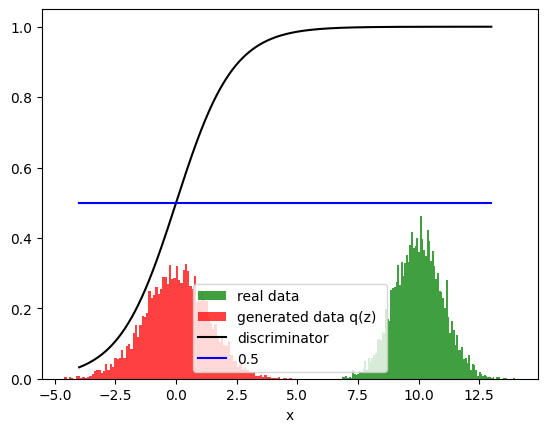

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

0.6652671098709106


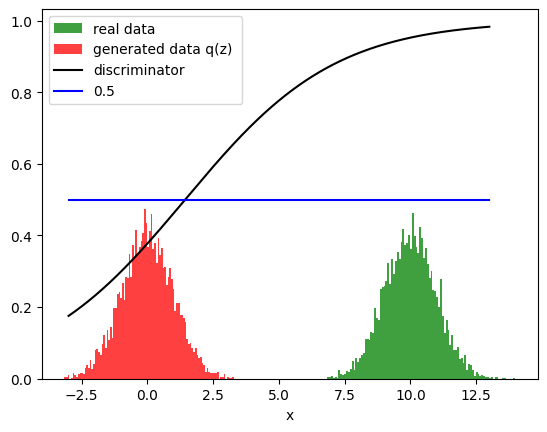

  5%|▌         | 1/20 [00:02<00:38,  2.01s/it]

epoch 0
0.6367720365524292


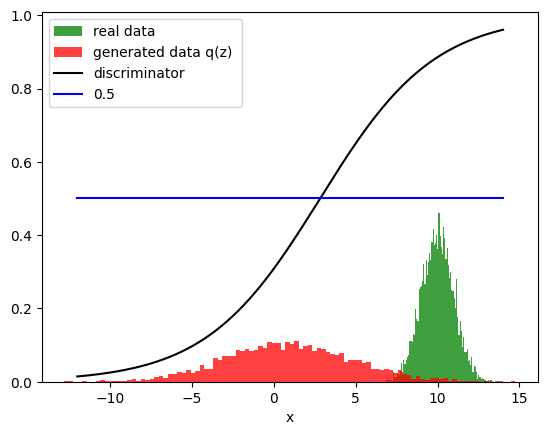

 25%|██▌       | 5/20 [00:02<00:05,  2.61it/s]

epoch 2
0.6225786209106445


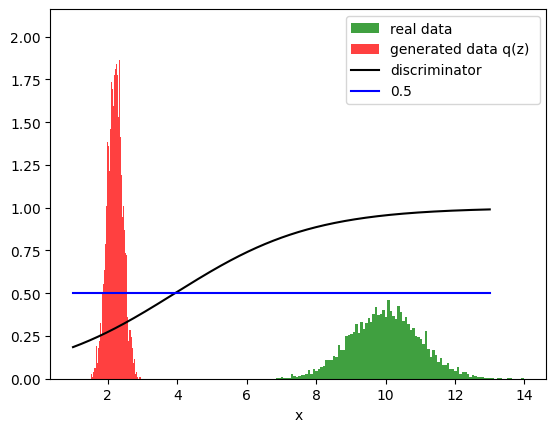

 35%|███▌      | 7/20 [00:03<00:04,  2.66it/s]

epoch 6
0.5150627493858337


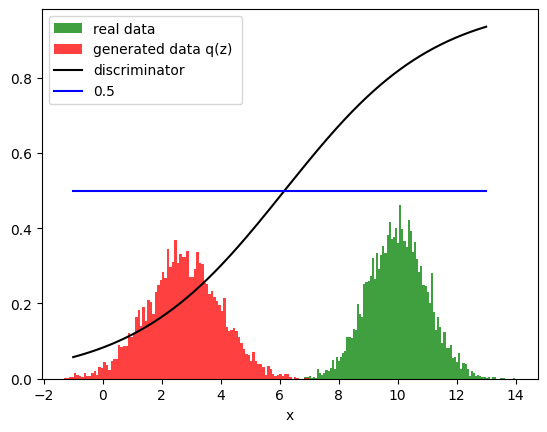

 45%|████▌     | 9/20 [00:04<00:05,  2.14it/s]

epoch 7


 55%|█████▌    | 11/20 [00:05<00:02,  3.25it/s]

0.5003394484519958


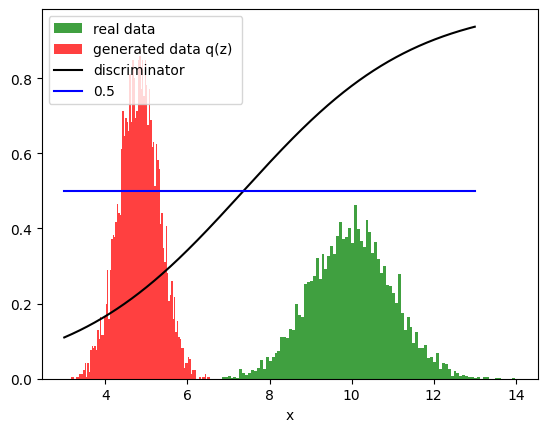

 70%|███████   | 14/20 [00:06<00:01,  3.41it/s]

epoch 11


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


In [ ]:
#parameters for training
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the standard deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        generator.save('generator.keras')
        discriminator.save('discriminator.keras')
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

For more on training GANs check out the following <a href="https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01">blog</a>. We can display the best performing model


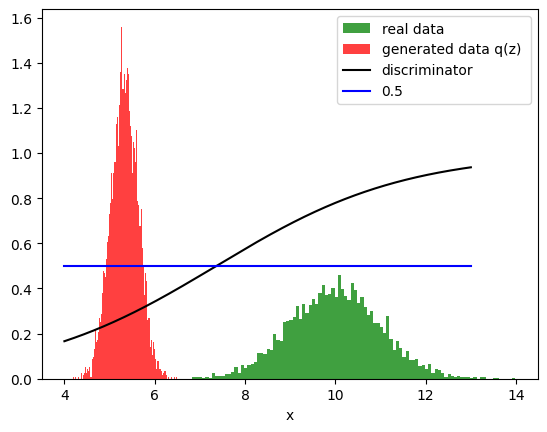

In [ ]:
generator=make_generator_model()
generator= models.load_model('generator.keras')
xhat=generator(z)
discriminator=models.load_model('discriminator.keras')
plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )

----


In the content above, you learned about the working mechanics of Generative Adversarial Networks (GANs) and their various applications, such as Image Generation. However, GANs have also been known to be unstable to train, and often, the generated images suffer from being noisy and incomprehensible.

For a improved result in the case example, we are applying Convolutional Neural Networks to GANS. They are called Deep Convolutional Generative Adversarial Networks (DCGANs).
We will build and train DCGANs in the following content, using several approaches introduced in the original <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1511.06434.pdf">DCGANs paper</a>.



----


## Deep Convolutional Generative Adversarial Networks (DCGANs)


### Case background


In the case example, you work for an online anime video game company; the company would like to create a unique anime avatar for a game for each player. As there are millions of players, you must use a DCGANs to create each character.

The proposed approaches are summarized here:

- Replace any pooling layers with **strided convolutions (discriminator)** and **fractional-strided
convolutions (generator)**.
- Use **batchnorm** in both the generator and the discriminator.
- **Remove fully connected hidden layers** for deeper architectures.
- Use **ReLU** activation in generator for all layers except for the output, which uses **Tanh**.
- Use **LeakyReLU** activation in the discriminator for all layers except for the output, which uses **Sigmoid**.
- Use **Adam optimizer**.  

These approaches will result in more stable training of deeper generative models.


### Loading the Dataset

We will mainly work with the Anime Face dataset from [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01). The original dataset has 63,632 "high-quality" anime faces, but to make the models train faster in this lab, we randomly sampled 20,000 images and prepared a dataset called `cartoon_20000`.

Let's download the smaller dataset using the Skills Network library's `prepare` function:


In [ ]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

Saved to '.'


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

The Anime Face or the Cartoon images are stored in the `cartoon_2000` folder in your current working directory. As a preprocessing step, we have removed any files that are not proper image formats (based on the file extensions) and any duplicate images.


### Creating Data Generator


First, we declare some properties of our images, including image height, image width, and batch size.


In [ ]:
img_height, img_width, batch_size=64,64,128

Next, we create a Keras <code>image_dataset_from_directory</code> object with a specified image directory and the parameters are defined as above. This process may take some time:


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000',
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)

Found 20000 files.


The `train_ds` we defined is a `tf.data.Dataset` that yields batches of images with `image_size = (64, 64)` from the directory specified or subdirectories (if any).


**(OPTIONAL)** If you are running this notebook locally and you have multiple cores, then we can use the runtime to tune the value dynamically at runtime as follows:


In [ ]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

We apply the Lambda function on `train_ds` to normalize the pixel values of all the input images from $[0, 255]$ to $[-1, 1]$:


In [ ]:
normalization_layer = layers.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

Let's take one batch of images for displaying:


In [ ]:
images=train_ds.take(1)

Convert the batch dimension to the indexes in a list:


In [ ]:
X=[x for x in images]

We can then plot the first five images in the batch using the function   ```plot_array```:


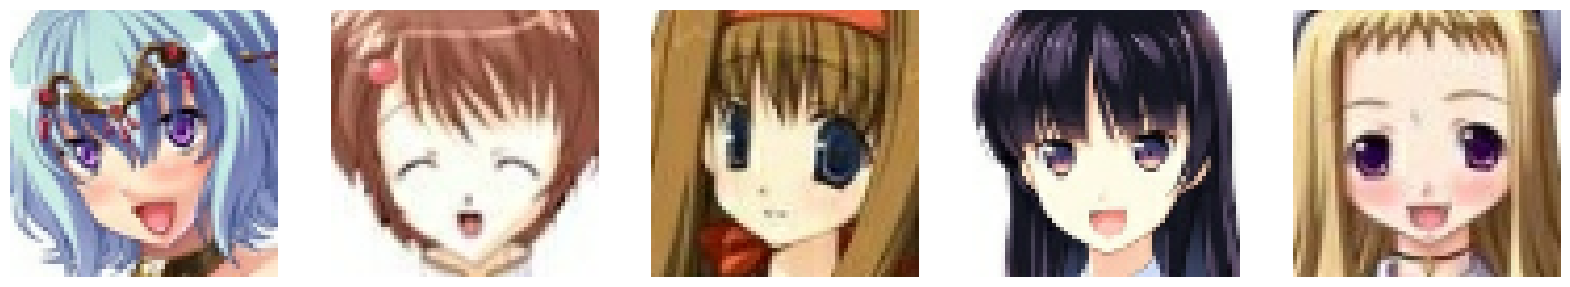

In [ ]:
plot_array(X[0])

###  Generator and Discriminator (for DCGANs)


___Building the Generator___


The Generator is comprised of several layers of transposed convolution, the opposite of convolution operations.

- Each Conv2DTranspose layer (except the final layer) is followed by a Batch Normalization layer and a **Relu activation**; for more implementation details, check out <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1511.06434.pdf">[2]</a>.
- The final transpose convolution layer has three output channels since the output needs to be a color image. We use the **Tanh activation** in the final layer.

See the illustration of the architecture from <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1511.06434.pdf">[2]</a> below.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/generator.png" alt="generator image" width="80%"></center>


We build the Generator network by using the parameter values from <a href="https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01" >[3]<a>.


In [ ]:
from tensorflow.keras import Model

def make_generator():
    # Create input layer explicitly
    inputs = Input(shape=(1, 1, 100), name='input_layer')

    # Block 1: input is latent vector -> 4x4x512
    x = Conv2DTranspose(64 * 8, kernel_size=4, strides=4, padding='same',
                       kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                       use_bias=False, name='conv_transpose_1')(inputs)
    x = BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = ReLU(name='relu_1')(x)

    # Block 2: 4x4x512 -> 8x8x256
    x = Conv2DTranspose(64 * 4, kernel_size=4, strides=2, padding='same',
                       kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                       use_bias=False, name='conv_transpose_2')(x)
    x = BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = ReLU(name='relu_2')(x)

    # Block 3: 8x8x256 -> 16x16x128
    x = Conv2DTranspose(64 * 2, kernel_size=4, strides=2, padding='same',
                       kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                       use_bias=False, name='conv_transpose_3')(x)
    x = BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02, name='bn_3')(x)
    x = ReLU(name='relu_3')(x)

    # Block 4: 16x16x128 -> 32x32x64
    x = Conv2DTranspose(64 * 1, kernel_size=4, strides=2, padding='same',
                       kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                       use_bias=False, name='conv_transpose_4')(x)
    x = BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02, name='bn_4')(x)
    x = ReLU(name='relu_4')(x)

    # Final Block: 32x32x64 -> 64x64x3
    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                            use_bias=False, activation='tanh',
                            name='conv_transpose_5')(x)

    # Create model using functional API
    model = Model(inputs=inputs, outputs=outputs, name='generator')

    return model

By printing the summary of the Generator architecture, we can see that the transposed convolutions **upsample** a 100-dim input vector to a high-dimensional image of size 64 x 64 x 3.


In [ ]:
gen = make_generator()
gen.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose_1 (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1 (BatchNormalization)            │ (None, 4, 4, 512)           │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu_1 (ReLU)                        │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose_2 (Conv2DTranspose)   │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2 (BatchNormalization)            │ (None, 8, 8, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu_2 (ReLU)                        │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose_3 (Conv2DTranspose)   │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_3 (BatchNormalization)            │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu_3 (ReLU)                        │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose_4 (Conv2DTranspose)   │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_4 (BatchNormalization)            │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu_4 (ReLU)                        │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose_5 (Conv2DTranspose)   │ (None, 64, 64, 3)           │           3,072 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,578,624 (13.65 MB)

 Trainable params: 3,576,704 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

___Building the Discriminator___


The Discriminator has five convolution layers.

- All but the first and final Conv2D layers have Batch Normalization, since directly applying batchnorm to all layers could result in sample oscillation and model instability;
- The first four Conv2D layers use the **Leaky-Relu activation** with a slope of 0.2.
- Lastly, instead of a fully connected layer, the  output layer has a convolution layer with a **Sigmoid activation** function.


In [ ]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

By printing the summary of the Discriminator architecture, we can see that the strided convolutions **downsample** an input image of size 64 x 64 x 3.


In [ ]:
disc = make_discriminator()
disc.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 32, 32, 64)          │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu_1 (LeakyReLU)             │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1 (BatchNormalization)            │ (None, 16, 16, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu_2 (LeakyReLU)             │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2 (BatchNormalization)            │ (None, 8, 8, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu_3 (LeakyReLU)             │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_3 (BatchNormalization)            │ (None, 4, 4, 512)           │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_relu_4 (LeakyReLU)             │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5 (Conv2D)                      │ (None, 2, 2, 1)             │           8,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,767,360 (10.56 MB)

 Trainable params: 2,765,568 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Defining Loss Functions

As we discussed in the previous section, the min-max optimization problem can be formulated by minimizing the cross entropy loss for the Generator and Discriminator.  

The `cross_entropy` object is the Binary Cross Entropy loss that will be used to model the objectives of the two networks.


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [ ]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

### Defining Optimizers

We create two Adam optimizers for the discriminator and the generator, respectively. We pass the following arguments to the optimizers:

- learning rate of 0.0002.
- beta coefficients $\beta_1 = 0.5$ and $\beta_2 = 0.999$, which are responsible for computing the running averages of the gradients during backpropagation.


In [ ]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

### Create Train Step Function

As this lab is more computationally intensive than the last lab, we convert the training step into a function and then use the  @tf.function decorator, which allows the function to be "compiled" into a **callable TensorFlow graph**. This will speed up the training; for more information, read <a href="https://www.tensorflow.org/guide/function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01">here </a>


In [ ]:
@tf.function

def train_step(X):

    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)

        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Don't be intimidated by the code above, here is a summary of what a train step accomplishes:

- First, we sample `z`, a batch of noise vectors from a normal distribution ($\mu = 1, \sigma = 1$) and feed it to the Generator.
- The Generator produces generated or "fake" images `xhat`.
- We feed real images `X` and fake images `xhat` to the Discriminator and obtain `real_output` and `fake_output` respectively as the scores.
- We calculate Generator loss `gen_loss` using the `fake_output` from Discriminator since we want the fake images to fool the Discriminator as much as possible.
- We calculate Discriminator loss `disc_loss` using both the `real_output` and `fake_output` since we want the Discriminator to distinguish the two as much as possible.
- We calculate `gradients_of_generator` and  `gradients_of_discriminator` based on the losses obtained.
- Finally, we update the Generator and Discriminator by letting their respective optimizers apply the processed gradients on the trainable model parameters.


We can transform the random noise using the generator. As the generator is not trained yet, the output appears to be noises:


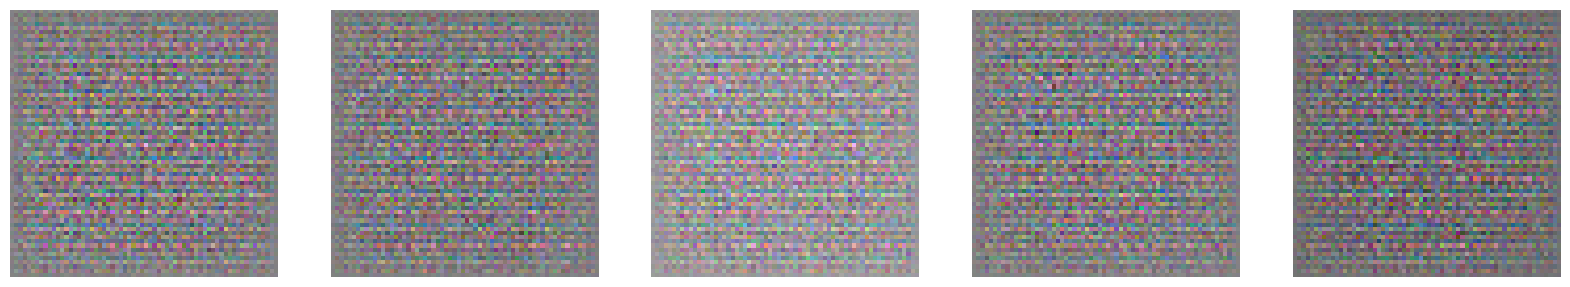

In [ ]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

### Training DCGANs


As this method is computationally intensive, we will train the model for one epoch and then use the generator to produce artificial images.

__Even 1 epoch in DCGANs training takes long time.__ You can __stop the training__ here and import the pre-trained model following the instruction below.


epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1, iteration 1


epoch 1:   1%|          | 1/157 [00:02<07:16,  2.80s/it]

epoch 1, iteration 2


epoch 1:   1%|▏         | 2/157 [00:03<03:32,  1.37s/it]

epoch 1, iteration 3


epoch 1:   2%|▏         | 3/157 [00:03<02:18,  1.11it/s]

epoch 1, iteration 4


epoch 1:   3%|▎         | 4/157 [00:03<01:44,  1.46it/s]

epoch 1, iteration 5


epoch 1:   3%|▎         | 5/157 [00:04<01:25,  1.77it/s]

epoch 1, iteration 6


epoch 1:   4%|▍         | 6/157 [00:04<01:14,  2.03it/s]

epoch 1, iteration 7


epoch 1:   4%|▍         | 7/157 [00:04<01:08,  2.20it/s]

epoch 1, iteration 8


epoch 1:   5%|▌         | 8/157 [00:05<01:02,  2.38it/s]

epoch 1, iteration 9


epoch 1:   6%|▌         | 9/157 [00:05<00:59,  2.50it/s]

epoch 1, iteration 10


epoch 1:   6%|▋         | 10/157 [00:06<00:57,  2.57it/s]

epoch 1, iteration 11


epoch 1:   7%|▋         | 11/157 [00:06<00:56,  2.61it/s]

epoch 1, iteration 12


epoch 1:   8%|▊         | 12/157 [00:06<00:54,  2.65it/s]

epoch 1, iteration 13


epoch 1:   8%|▊         | 13/157 [00:07<00:53,  2.70it/s]

epoch 1, iteration 14


epoch 1:   9%|▉         | 14/157 [00:07<00:53,  2.68it/s]

epoch 1, iteration 15


epoch 1:  10%|▉         | 15/157 [00:07<00:52,  2.69it/s]

epoch 1, iteration 16


epoch 1:  10%|█         | 16/157 [00:08<00:51,  2.72it/s]

epoch 1, iteration 17


epoch 1:  11%|█         | 17/157 [00:08<00:51,  2.72it/s]

epoch 1, iteration 18


epoch 1:  11%|█▏        | 18/157 [00:08<00:51,  2.71it/s]

epoch 1, iteration 19


epoch 1:  12%|█▏        | 19/157 [00:09<00:50,  2.72it/s]

epoch 1, iteration 20


epoch 1:  13%|█▎        | 20/157 [00:09<00:49,  2.76it/s]

epoch 1, iteration 21


epoch 1:  13%|█▎        | 21/157 [00:10<00:48,  2.78it/s]

epoch 1, iteration 22


epoch 1:  14%|█▍        | 22/157 [00:10<00:48,  2.77it/s]

epoch 1, iteration 23


epoch 1:  15%|█▍        | 23/157 [00:10<00:48,  2.79it/s]

epoch 1, iteration 24


epoch 1:  15%|█▌        | 24/157 [00:11<00:47,  2.81it/s]

epoch 1, iteration 25


epoch 1:  16%|█▌        | 25/157 [00:11<00:46,  2.84it/s]

epoch 1, iteration 26


epoch 1:  17%|█▋        | 26/157 [00:11<00:46,  2.82it/s]

epoch 1, iteration 27


epoch 1:  17%|█▋        | 27/157 [00:12<00:47,  2.76it/s]

epoch 1, iteration 28


epoch 1:  18%|█▊        | 28/157 [00:12<00:49,  2.59it/s]

epoch 1, iteration 29


epoch 1:  18%|█▊        | 29/157 [00:13<00:52,  2.43it/s]

epoch 1, iteration 30


epoch 1:  19%|█▉        | 30/157 [00:13<00:54,  2.33it/s]

epoch 1, iteration 31


epoch 1:  20%|█▉        | 31/157 [00:14<00:55,  2.26it/s]

epoch 1, iteration 32


epoch 1:  20%|██        | 32/157 [00:14<00:56,  2.20it/s]

epoch 1, iteration 33


epoch 1:  21%|██        | 33/157 [00:15<00:58,  2.13it/s]

epoch 1, iteration 34


epoch 1:  22%|██▏       | 34/157 [00:15<00:57,  2.13it/s]

epoch 1, iteration 35


epoch 1:  22%|██▏       | 35/157 [00:15<00:53,  2.28it/s]

epoch 1, iteration 36


epoch 1:  23%|██▎       | 36/157 [00:16<00:50,  2.41it/s]

epoch 1, iteration 37


epoch 1:  24%|██▎       | 37/157 [00:16<00:47,  2.51it/s]

epoch 1, iteration 38


epoch 1:  24%|██▍       | 38/157 [00:16<00:45,  2.60it/s]

epoch 1, iteration 39


epoch 1:  25%|██▍       | 39/157 [00:17<00:44,  2.66it/s]

epoch 1, iteration 40


epoch 1:  25%|██▌       | 40/157 [00:17<00:43,  2.68it/s]

epoch 1, iteration 41


epoch 1:  26%|██▌       | 41/157 [00:17<00:42,  2.72it/s]

epoch 1, iteration 42


epoch 1:  27%|██▋       | 42/157 [00:18<00:41,  2.76it/s]

epoch 1, iteration 43


epoch 1:  27%|██▋       | 43/157 [00:18<00:40,  2.79it/s]

epoch 1, iteration 44


epoch 1:  28%|██▊       | 44/157 [00:19<00:40,  2.82it/s]

epoch 1, iteration 45


epoch 1:  29%|██▊       | 45/157 [00:19<00:39,  2.83it/s]

epoch 1, iteration 46


epoch 1:  29%|██▉       | 46/157 [00:19<00:39,  2.83it/s]

epoch 1, iteration 47


epoch 1:  30%|██▉       | 47/157 [00:20<00:38,  2.85it/s]

epoch 1, iteration 48


epoch 1:  31%|███       | 48/157 [00:20<00:38,  2.83it/s]

epoch 1, iteration 49


epoch 1:  31%|███       | 49/157 [00:20<00:38,  2.81it/s]

epoch 1, iteration 50


epoch 1:  32%|███▏      | 50/157 [00:21<00:38,  2.81it/s]

epoch 1, iteration 51


epoch 1:  32%|███▏      | 51/157 [00:21<00:38,  2.79it/s]

epoch 1, iteration 52


epoch 1:  33%|███▎      | 52/157 [00:21<00:37,  2.79it/s]

epoch 1, iteration 53


epoch 1:  34%|███▍      | 53/157 [00:22<00:37,  2.78it/s]

epoch 1, iteration 54


epoch 1:  34%|███▍      | 54/157 [00:22<00:37,  2.77it/s]

epoch 1, iteration 55


epoch 1:  35%|███▌      | 55/157 [00:22<00:36,  2.76it/s]

epoch 1, iteration 56


epoch 1:  36%|███▌      | 56/157 [00:23<00:36,  2.75it/s]

epoch 1, iteration 57


epoch 1:  36%|███▋      | 57/157 [00:23<00:36,  2.76it/s]

epoch 1, iteration 58


epoch 1:  37%|███▋      | 58/157 [00:24<00:35,  2.79it/s]

epoch 1, iteration 59


epoch 1:  38%|███▊      | 59/157 [00:24<00:35,  2.80it/s]

epoch 1, iteration 60


epoch 1:  38%|███▊      | 60/157 [00:24<00:34,  2.79it/s]

epoch 1, iteration 61


epoch 1:  39%|███▉      | 61/157 [00:25<00:34,  2.78it/s]

epoch 1, iteration 62


epoch 1:  39%|███▉      | 62/157 [00:25<00:35,  2.64it/s]

epoch 1, iteration 63


epoch 1:  40%|████      | 63/157 [00:26<00:37,  2.47it/s]

epoch 1, iteration 64


epoch 1:  41%|████      | 64/157 [00:26<00:37,  2.45it/s]

epoch 1, iteration 65


epoch 1:  41%|████▏     | 65/157 [00:26<00:38,  2.41it/s]

epoch 1, iteration 66


epoch 1:  42%|████▏     | 66/157 [00:27<00:38,  2.33it/s]

epoch 1, iteration 67


epoch 1:  43%|████▎     | 67/157 [00:27<00:39,  2.30it/s]

epoch 1, iteration 68


epoch 1:  43%|████▎     | 68/157 [00:28<00:38,  2.32it/s]

epoch 1, iteration 69


epoch 1:  44%|████▍     | 69/157 [00:28<00:35,  2.47it/s]

epoch 1, iteration 70


epoch 1:  45%|████▍     | 70/157 [00:28<00:34,  2.49it/s]

epoch 1, iteration 71


epoch 1:  45%|████▌     | 71/157 [00:29<00:33,  2.57it/s]

epoch 1, iteration 72


epoch 1:  46%|████▌     | 72/157 [00:29<00:32,  2.63it/s]

epoch 1, iteration 73


epoch 1:  46%|████▋     | 73/157 [00:30<00:31,  2.63it/s]

epoch 1, iteration 74


epoch 1:  47%|████▋     | 74/157 [00:30<00:31,  2.64it/s]

epoch 1, iteration 75


epoch 1:  48%|████▊     | 75/157 [00:30<00:30,  2.69it/s]

epoch 1, iteration 76


epoch 1:  48%|████▊     | 76/157 [00:31<00:29,  2.71it/s]

epoch 1, iteration 77


epoch 1:  49%|████▉     | 77/157 [00:31<00:29,  2.72it/s]

epoch 1, iteration 78


epoch 1:  50%|████▉     | 78/157 [00:31<00:28,  2.74it/s]

epoch 1, iteration 79


epoch 1:  50%|█████     | 79/157 [00:32<00:28,  2.75it/s]

epoch 1, iteration 80


epoch 1:  51%|█████     | 80/157 [00:32<00:28,  2.74it/s]

epoch 1, iteration 81


epoch 1:  52%|█████▏    | 81/157 [00:32<00:28,  2.71it/s]

epoch 1, iteration 82


epoch 1:  52%|█████▏    | 82/157 [00:33<00:27,  2.70it/s]

epoch 1, iteration 83


epoch 1:  53%|█████▎    | 83/157 [00:33<00:27,  2.70it/s]

epoch 1, iteration 84


epoch 1:  54%|█████▎    | 84/157 [00:34<00:27,  2.70it/s]

epoch 1, iteration 85


epoch 1:  54%|█████▍    | 85/157 [00:34<00:26,  2.73it/s]

epoch 1, iteration 86


epoch 1:  55%|█████▍    | 86/157 [00:34<00:25,  2.75it/s]

epoch 1, iteration 87


epoch 1:  55%|█████▌    | 87/157 [00:35<00:26,  2.68it/s]

epoch 1, iteration 88


epoch 1:  56%|█████▌    | 88/157 [00:35<00:25,  2.69it/s]

epoch 1, iteration 89


epoch 1:  57%|█████▋    | 89/157 [00:35<00:25,  2.72it/s]

epoch 1, iteration 90


epoch 1:  57%|█████▋    | 90/157 [00:36<00:24,  2.72it/s]

epoch 1, iteration 91


epoch 1:  58%|█████▊    | 91/157 [00:36<00:23,  2.75it/s]

epoch 1, iteration 92


epoch 1:  59%|█████▊    | 92/157 [00:36<00:23,  2.79it/s]

epoch 1, iteration 93


epoch 1:  59%|█████▉    | 93/157 [00:37<00:22,  2.80it/s]

epoch 1, iteration 94


epoch 1:  60%|█████▉    | 94/157 [00:37<00:22,  2.82it/s]

epoch 1, iteration 95


epoch 1:  61%|██████    | 95/157 [00:38<00:21,  2.83it/s]

epoch 1, iteration 96


epoch 1:  61%|██████    | 96/157 [00:38<00:23,  2.64it/s]

epoch 1, iteration 97


epoch 1:  62%|██████▏   | 97/157 [00:38<00:23,  2.53it/s]

epoch 1, iteration 98


epoch 1:  62%|██████▏   | 98/157 [00:39<00:23,  2.48it/s]

epoch 1, iteration 99


epoch 1:  63%|██████▎   | 99/157 [00:39<00:24,  2.41it/s]

epoch 1, iteration 100


epoch 1:  64%|██████▎   | 100/157 [00:40<00:24,  2.31it/s]

epoch 1, iteration 101


epoch 1:  64%|██████▍   | 101/157 [00:40<00:24,  2.28it/s]

epoch 1, iteration 102


epoch 1:  65%|██████▍   | 102/157 [00:41<00:22,  2.42it/s]

epoch 1, iteration 103


epoch 1:  66%|██████▌   | 103/157 [00:41<00:21,  2.52it/s]

epoch 1, iteration 104


epoch 1:  66%|██████▌   | 104/157 [00:41<00:20,  2.60it/s]

epoch 1, iteration 105


epoch 1:  67%|██████▋   | 105/157 [00:42<00:19,  2.67it/s]

epoch 1, iteration 106


epoch 1:  68%|██████▊   | 106/157 [00:42<00:18,  2.71it/s]

epoch 1, iteration 107


epoch 1:  68%|██████▊   | 107/157 [00:42<00:18,  2.75it/s]

epoch 1, iteration 108


epoch 1:  69%|██████▉   | 108/157 [00:43<00:17,  2.80it/s]

epoch 1, iteration 109


epoch 1:  69%|██████▉   | 109/157 [00:43<00:16,  2.83it/s]

epoch 1, iteration 110


epoch 1:  70%|███████   | 110/157 [00:43<00:16,  2.83it/s]

epoch 1, iteration 111


epoch 1:  71%|███████   | 111/157 [00:44<00:16,  2.81it/s]

epoch 1, iteration 112


epoch 1:  71%|███████▏  | 112/157 [00:44<00:16,  2.79it/s]

epoch 1, iteration 113


epoch 1:  72%|███████▏  | 113/157 [00:44<00:15,  2.78it/s]

epoch 1, iteration 114


epoch 1:  73%|███████▎  | 114/157 [00:45<00:15,  2.79it/s]

epoch 1, iteration 115


epoch 1:  73%|███████▎  | 115/157 [00:45<00:15,  2.76it/s]

epoch 1, iteration 116


epoch 1:  74%|███████▍  | 116/157 [00:46<00:14,  2.78it/s]

epoch 1, iteration 117


epoch 1:  75%|███████▍  | 117/157 [00:46<00:14,  2.82it/s]

epoch 1, iteration 118


epoch 1:  75%|███████▌  | 118/157 [00:46<00:13,  2.80it/s]

epoch 1, iteration 119


epoch 1:  76%|███████▌  | 119/157 [00:47<00:13,  2.81it/s]

epoch 1, iteration 120


epoch 1:  76%|███████▋  | 120/157 [00:47<00:13,  2.77it/s]

epoch 1, iteration 121


epoch 1:  77%|███████▋  | 121/157 [00:47<00:13,  2.77it/s]

epoch 1, iteration 122


epoch 1:  78%|███████▊  | 122/157 [00:48<00:12,  2.77it/s]

epoch 1, iteration 123


epoch 1:  78%|███████▊  | 123/157 [00:48<00:12,  2.74it/s]

epoch 1, iteration 124


epoch 1:  79%|███████▉  | 124/157 [00:48<00:12,  2.72it/s]

epoch 1, iteration 125


epoch 1:  80%|███████▉  | 125/157 [00:49<00:11,  2.74it/s]

epoch 1, iteration 126


epoch 1:  80%|████████  | 126/157 [00:49<00:11,  2.75it/s]

epoch 1, iteration 127


epoch 1:  81%|████████  | 127/157 [00:50<00:10,  2.76it/s]

epoch 1, iteration 128


epoch 1:  82%|████████▏ | 128/157 [00:50<00:10,  2.77it/s]

epoch 1, iteration 129


epoch 1:  82%|████████▏ | 129/157 [00:50<00:10,  2.70it/s]

epoch 1, iteration 130


epoch 1:  83%|████████▎ | 130/157 [00:51<00:10,  2.47it/s]

epoch 1, iteration 131


epoch 1:  83%|████████▎ | 131/157 [00:51<00:11,  2.35it/s]

epoch 1, iteration 132


epoch 1:  84%|████████▍ | 132/157 [00:52<00:10,  2.34it/s]

epoch 1, iteration 133


epoch 1:  85%|████████▍ | 133/157 [00:52<00:10,  2.26it/s]

epoch 1, iteration 134


epoch 1:  85%|████████▌ | 134/157 [00:53<00:10,  2.22it/s]

epoch 1, iteration 135


epoch 1:  86%|████████▌ | 135/157 [00:53<00:09,  2.22it/s]

epoch 1, iteration 136


epoch 1:  87%|████████▋ | 136/157 [00:53<00:08,  2.36it/s]

epoch 1, iteration 137


epoch 1:  87%|████████▋ | 137/157 [00:54<00:08,  2.48it/s]

epoch 1, iteration 138


epoch 1:  88%|████████▊ | 138/157 [00:54<00:07,  2.61it/s]

epoch 1, iteration 139


epoch 1:  89%|████████▊ | 139/157 [00:54<00:06,  2.67it/s]

epoch 1, iteration 140


epoch 1:  89%|████████▉ | 140/157 [00:55<00:06,  2.69it/s]

epoch 1, iteration 141


epoch 1:  90%|████████▉ | 141/157 [00:55<00:05,  2.73it/s]

epoch 1, iteration 142


epoch 1:  90%|█████████ | 142/157 [00:56<00:05,  2.75it/s]

epoch 1, iteration 143


epoch 1:  91%|█████████ | 143/157 [00:56<00:05,  2.76it/s]

epoch 1, iteration 144


epoch 1:  92%|█████████▏| 144/157 [00:56<00:04,  2.71it/s]

epoch 1, iteration 145


epoch 1:  92%|█████████▏| 145/157 [00:57<00:04,  2.75it/s]

epoch 1, iteration 146


epoch 1:  93%|█████████▎| 146/157 [00:57<00:04,  2.74it/s]

epoch 1, iteration 147


epoch 1:  94%|█████████▎| 147/157 [00:57<00:03,  2.75it/s]

epoch 1, iteration 148


epoch 1:  94%|█████████▍| 148/157 [00:58<00:03,  2.76it/s]

epoch 1, iteration 149


epoch 1:  95%|█████████▍| 149/157 [00:58<00:02,  2.79it/s]

epoch 1, iteration 150


epoch 1:  96%|█████████▌| 150/157 [00:58<00:02,  2.81it/s]

epoch 1, iteration 151


epoch 1:  96%|█████████▌| 151/157 [00:59<00:02,  2.81it/s]

epoch 1, iteration 152


epoch 1:  97%|█████████▋| 152/157 [00:59<00:01,  2.88it/s]

epoch 1, iteration 153


epoch 1:  97%|█████████▋| 153/157 [00:59<00:01,  2.88it/s]

epoch 1, iteration 154


epoch 1:  98%|█████████▊| 154/157 [01:00<00:01,  2.88it/s]

epoch 1, iteration 155


epoch 1:  99%|█████████▊| 155/157 [01:00<00:00,  2.89it/s]

epoch 1, iteration 156


epoch 1:  99%|█████████▉| 156/157 [01:00<00:00,  2.88it/s]

epoch 1, iteration 157


epoch 1: 100%|██████████| 157/157 [01:21<00:00,  1.92it/s]


orignal images


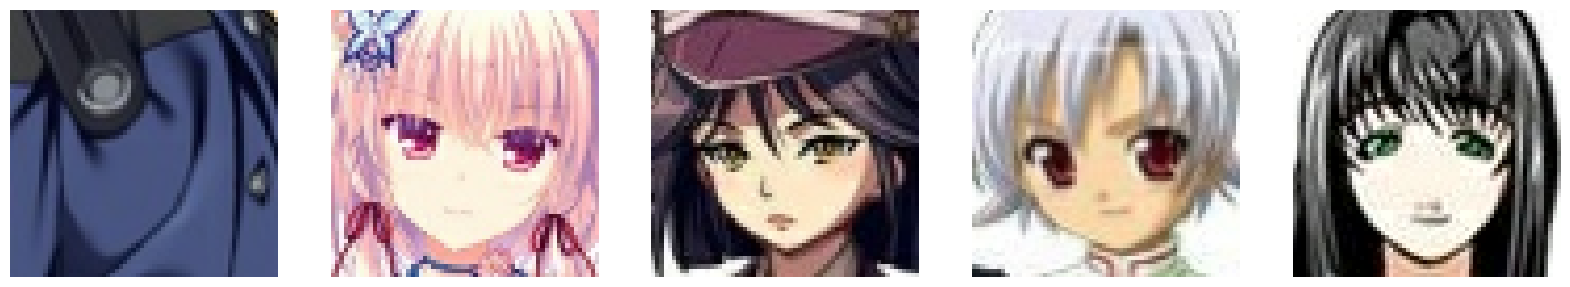

generated images


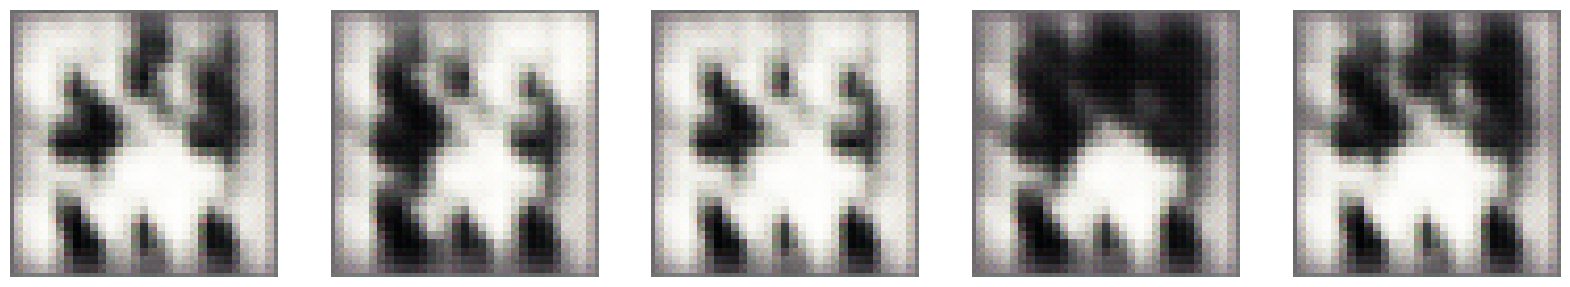

Time for epoch 1 is 86.50630378723145 sec


In [ ]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):

    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):

        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))

        train_step(X)


    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

As you can see that, with only one epoch of training and a reduced number of training images, our GAN didn't learn much information, and thus, the generator wasn't able to produce images that make sense to human eyes. There are two quick actions you can take to try to improve the results:

1. Re-train the GAN using the full dataset that has 63,632 images.
    - To do so, simply go back to the **Loading the Dataset** section in **DCGANs**, replace the url of the dataset with "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/cartoon_data.tgz", change the `directory` argument in `tf.keras.utils.image_dataset_from_directory` to `'cartoon_data'` in **Creating data generator** section and re-run all the cells.
    - Note that using more training data does allows the model to learn better and perform better, but it will result in longer training time! **With 63K training images and batch size of 128, your model will train for ~497 iterations.**


2. Use a pre-trained generator model to generate images.
    - You don't need to experience the training time at all!
    - Proceed to the next subsection to load a pre-trained model, and you will see that the generator trained with 150 epochs can produce almost realistic anime faces.


___Loading Pre-trained model (150 epochs)___


As you saw, training a GAN with only one epoch takes quite a long time. If we want to evaluate the performance of a fully trained and optimized GAN, we would need to increase the number of epochs.
Thus, to help you **avoid extremely long training time** in this lab, we will just **download the pre-trained Generator network parameters** and then use Kera `load_model` function to obtain a **pre-trained Generator**, which we will use to generate images directly.


In [ ]:
generator_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/data/generator.tar"
await skillsnetwork.prepare(generator_url, overwrite=True)

  0%|          | 0/7 [00:00<?, ?it/s]

Saved to '.'


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Load the generator:


In [ ]:
from tensorflow.keras.models import load_model


full_generator=load_model("generator.keras")

Let's generate several images using the fully trained Generator and display them:


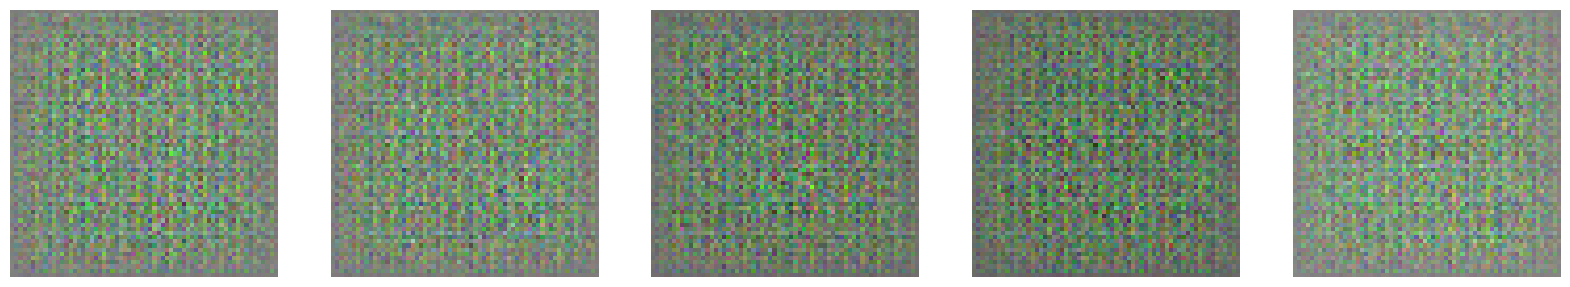

In [ ]:
# Create noise
latent_dim = 100
noise = tf.random.normal([200, 1, 1, latent_dim])

# Use the new generator 'gen' instead of 'full_generator'
Xhat = gen(noise, training=False)  # Use 'gen' here, not 'full_generator'
plot_array(Xhat)

## Explore Latent Variables

Values of $\mathbf{z}$ that are relatively close together will produce similar images. For example, we can assigns elements of $\mathbf{z}$ close values such as $[1,0.8,..,0.4]$.


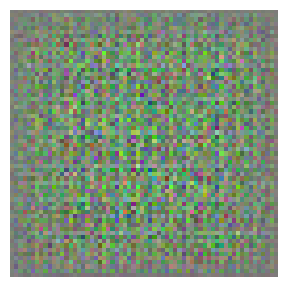

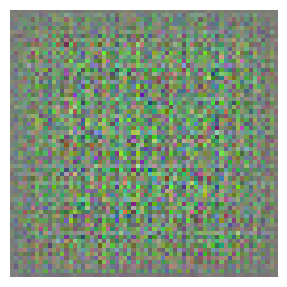

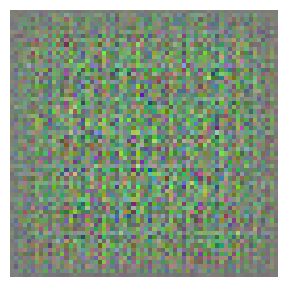

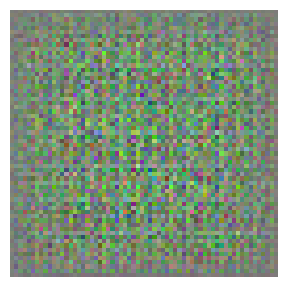

In [ ]:
for c in [1,0.8,0.6,0.4]:
    Xhat=gen(c*tf.ones([1, 1, 1, latent_dim]),training=False) # latent_dim = 100 defined previously
    plot_array(Xhat)

### Exercise 1

Plot the generated images by the Generator with elements of $\mathbf{z}$ equal $[-1,-0.8,-0.6,-0.4]$.


In [ ]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
    plot_array(Xhat)

NameError: name 'full_generator' is not defined

<details>
    <summary>Click here for Solution</summary>

```python
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
    plot_array(Xhat)
 ```   

</details>


We can see how changing the latent variable changes the generated image. Here we alter more and more subsequent values of $\mathbf{z}$ from 1 to -1; we see the images change accordingly; this is evident in the anime character's hair color:


In [ ]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(10):

    z[0, 0, 0, 0:10*n]=-1

    Xhat=full_generator(z,training=False)
    print("elements from 0 to {} is set to -1".format(10*n))
    plot_array(Xhat)

### Exercise 2

Repeat the above procedure but set the latent variable $z[0, 0, 0, 0:20*n] = -0.5*n$ each time `for n in range(5)`


<details>
    <summary>Click here for Solution</summary>

```python
z=np.ones( (1, 1, 1, latent_dim))
for n in range(5):

    z[0, 0, 0, 0:20*n]=-0.5*n

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

 ```   

</details>


We can also hold some of the elements of $\mathbf{z}$ constant and randomly change others. Here, we set the first 20 elements to one and randomly change the rest. We see that all through the images change, the hair color remains light.


In [ ]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

### Exercise 3

Repeat the procedure above, but set the elements of $\mathbf{z}$ from index 0 to 35 to -1


<details>
    <summary>Click here for Solution</summary>

```python

for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=-1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

 ```   

</details>


__Thank you for completing this lab!__
<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/unknown5.jpeg" width="500px"></center>


----


## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a> has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.

[Junxing(J.C.) Chen](https://www.linkedin.com/in/junxing-chen-3591a4162/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01) is a Data Scientist at IBM with strong interests in machine learning and cutting-edge technologies.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By  | Change Description |
| ----------------- | ------- | ----------- | ------------------ |
| 2022-08-30        | 0.1     | Joseph Santarcangelo  | Created Lab       |
| 2022-09-06        | 0.1     | Roxanne Li  | Reviewed and edited Lab       |
| 2022-09-23        | 0.1     | Steve Hord  | QA pass edits                 |
| 2022-10-11        | 0.2     | Junxing(J.C.) Chen  | Reviewed and edited Lab       |


Copyright © 2022 IBM Corporation. All rights reserved.
